In [1]:
# Importing Nescessary Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pathlib
import pandas as pd
import os
import zipfile
from PIL import Image

In [2]:
# Mounting Drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# extracting Folder from Zip-file
zip_folder = zipfile.ZipFile('/content/drive/MyDrive/cat_dog_cnn/cat_dog.zip','r')
zip_folder.extractall()
zip_folder.close()

In [4]:
# Defining Path for train and test dataset
train_dir = '/content/data/train'
test_dir = '/content/data/test'
valid_dir = '/content/data/validation'


train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size = 32,
                                                                 image_size = (224,224),
                                                                 label_mode = 'categorical'
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 batch_size = 32,
                                                                 image_size = (224,224),
                                                                 label_mode = 'categorical'
                                                                 )
validation_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                 batch_size = 32,
                                                                 image_size = (224,224),
                                                                 label_mode = 'categorical'
                                                                 )

# Data Augmentation ( increase complexity )
data_augmentataion = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(20),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2)
])

Found 200 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [ ]:
# Creating checkpoint Callback
callback_path = "checkpoint_weights/checkpoint.ckpt"

callback = keras.callbacks.ModelCheckpoint(filepath= callback_path,
                                           save_weights_only = True,
                                           save_best_only = False,
                                           save_freq = 'epoch')

In [ ]:
# Defining Base Model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating Layers for Model
inputs = layers.Input(shape=(224,224,3))
x = data_augmentataion(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation = 'softmax')(x)

model =  keras.Model(inputs,outputs)

# compiling The Model
model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

In [ ]:
# Fitting Model
history_1 = model.fit(train_data,
                      epochs = 5,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = len(test_data),
                      callbacks = [callback])


Epoch 1/5
7/7 [==============================] - 13s 775ms/step - loss: 0.7280 - accuracy: 0.5450 - val_loss: 0.5103 - val_accuracy: 0.7600
Epoch 2/5
7/7 [==============================] - 5s 569ms/step - loss: 0.5043 - accuracy: 0.7500 - val_loss: 0.3243 - val_accuracy: 0.9300
Epoch 3/5
7/7 [==============================] - 4s 476ms/step - loss: 0.3757 - accuracy: 0.8750 - val_loss: 0.2349 - val_accuracy: 0.9400
Epoch 4/5
7/7 [==============================] - 5s 678ms/step - loss: 0.2932 - accuracy: 0.8900 - val_loss: 0.1850 - val_accuracy: 0.9500
Epoch 5/5
7/7 [==============================] - 5s 541ms/step - loss: 0.2489 - accuracy: 0.9400 - val_loss: 0.1534 - val_accuracy: 0.9600


<Axes: >

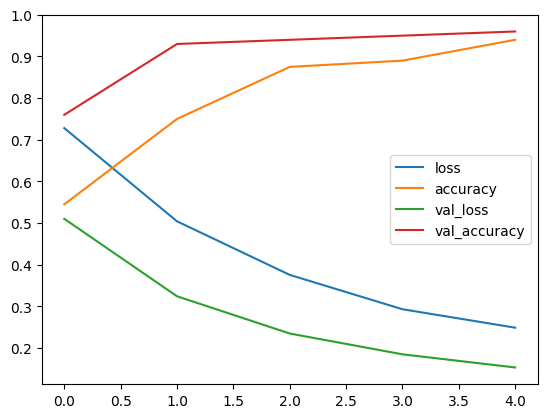

In [ ]:
# plotting First 5 epochs history

pd.DataFrame(history_1.history).plot()

# Using Fine-tuning

In [ ]:
# Traing the last 30 layes of base_model (EfficientnetB0) and Recompiling
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

In [ ]:
# Fitting Model
history_2 = model.fit(train_data,
                      epochs = 15,
                      steps_per_epoch = len(train_data),
                      initial_epoch = history_1.epoch[-1],
                      validation_data = test_data,
                      validation_steps = len(test_data),
                      callbacks = [callback])

Epoch 5/15
7/7 [==============================] - 17s 990ms/step - loss: 0.3416 - accuracy: 0.8550 - val_loss: 0.0692 - val_accuracy: 0.9700
Epoch 6/15
7/7 [==============================] - 5s 641ms/step - loss: 0.1073 - accuracy: 0.9500 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 5s 546ms/step - loss: 0.0578 - accuracy: 0.9800 - val_loss: 0.0638 - val_accuracy: 0.9700
Epoch 8/15
7/7 [==============================] - 5s 610ms/step - loss: 0.0572 - accuracy: 0.9900 - val_loss: 0.0164 - val_accuracy: 0.9800
Epoch 9/15
7/7 [==============================] - 4s 600ms/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 10/15
7/7 [==============================] - 4s 646ms/step - loss: 0.0224 - accuracy: 0.9900 - val_loss: 0.0384 - val_accuracy: 0.9700
Epoch 11/15
7/7 [==============================] - 4s 643ms/step - loss: 0.0192 - accuracy: 0.9850 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 12/15
7/7 [

<Axes: >

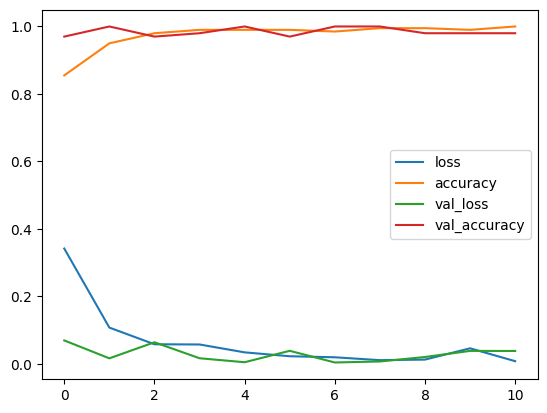

In [ ]:
# Plotting accuracy curves
pd.DataFrame(history_2.history).plot()

In [ ]:
# Saving Model
model.save("cat_dog_99.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Testing Model on Validation Data
valid_list = ["cats","dogs"]
val_data = [os.listdir(os.path.join('/content/data/validation', file)) for file in valid_list]
train_data_file = [os.listdir(os.path.join('/content/data/train', file)) for file in valid_list]
test_data_file = [os.listdir(os.path.join('/content/data/test', file)) for file in valid_list]

In [74]:
# Extracting Class names
c_p = pathlib.Path('/content/data/validation')
class_names = [item.name for item in c_p.glob('*')]
class_names.sort()
class_names

['cats', 'dogs']

In [ ]:
# Predicting all images from test dataset
answer = {'cats':[],'dogs':[]}
for dir_name,dirs in zip(valid_list,test_data_file):
  for files in dirs:
    img= Image.open(os.path.join('/content/data/test',dir_name,files))
    img = img.resize((224,224))
    img = tf.expand_dims(np.array(img),axis=0)
    pred = model.predict(img,verbose=0)
    answer[dir_name].append(pred.squeeze().tolist())
answer

In [ ]:
# Finding Labels from their corresponding prediction
result = {'cats':[],'dogs':[]}
for keys,val in answer.items():
  for d_val  in val:
    ind = d_val.index(max(d_val))
    pred = class_names[ind]
    result[keys].append(pred)
result

In [ ]:
# Accuracy on Test Data
accuracy = {'cats':[],'dogs':[]}
for keys,val in result.items():
  ans = val.count(keys)
  accuracy[keys].append(ans)
  accuracy[keys].append(len(val))
  accuracy[keys].append((ans/len(val)))

accuracy_mat = pd.DataFrame(accuracy).T.set_axis(['Total_predictions','Total_orginals','accuracy'],axis=1)
accuracy_mat

,Total_predictions,Total_orginals,accuracy
cats,48.0,50.0,0.96
dogs,48.0,50.0,0.96


In [ ]:
# Loading Model
load_model = keras.models.load_model('/content/drive/MyDrive/cat_dog_cnn/cat_dog_99.h5')

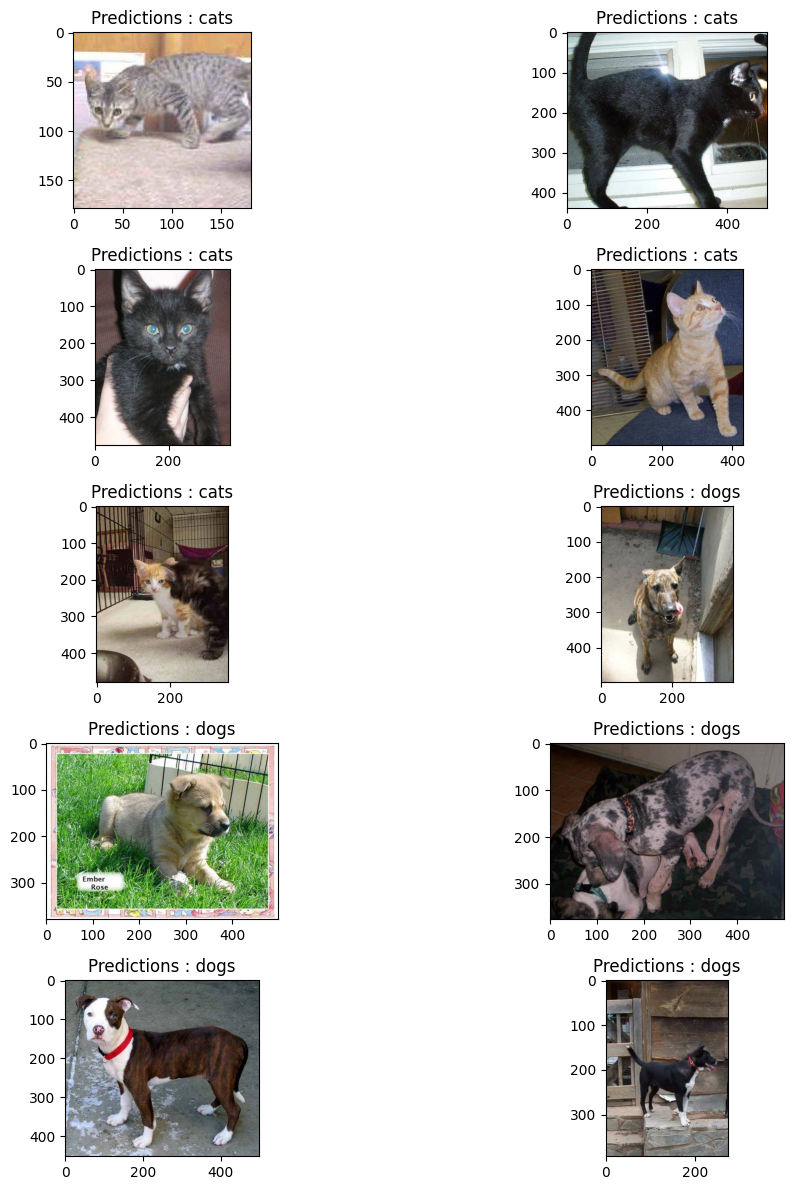

In [89]:
# Predction on 10 Random images with their predicted Labels
import random
images = [random.sample(os.listdir(os.path.join('/content/data/test',i)),5) for i in ['cats','dogs']]

import matplotlib.pyplot as plt
dirs = ['cats','dogs']
fig, ax = plt.subplots(5,2,figsize = (12,12))
ax = ax.flatten()
a=0

for j,img_name in zip(dirs,images):
  for img in img_name:
    image= os.path.join('/content/data/test',j,img)
    image = Image.open(image)
    resize_img = image.resize((224,224))
    img_arr = tf.expand_dims(np.array(resize_img),axis = 0)
    pred = load_model.predict(img_arr,verbose = 0)
    pred = pred.squeeze().tolist()
    result = class_names[pred.index(max(pred))]
    ax[a].imshow(image)
    ax[a].set_title(f"Predictions : {result}")
    a+=1


plt.tight_layout()

plt.show()